In [4]:
!pip install tensorflow
!pip install tifffile
!pip install matplotlib
!pip install scikit-learn

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define the paths to your data
images_path = '/content/drive/MyDrive/Mitochondria-Data/Data/train/training.tif'  # مسیر فایل تصاویر
masks_path = '/content/drive/MyDrive/Mitochondria-Data/Data/train/training_groundtruth.tif'    # مسیر فایل ماسک‌ها

# Load images and masks
images = tiff.imread(images_path)
masks = tiff.imread(masks_path)


In [6]:
print(f"Original images shape: {images.shape}")
print(f"Original masks shape: {masks.shape}")

if len(images.shape) == 3:
    images = np.expand_dims(images, axis=-1)
if len(masks.shape) == 3:
    masks = np.expand_dims(masks, axis=-1)

print(f"New images shape: {images.shape}")
print(f"New masks shape: {masks.shape}")

# Resize images if necessary
def resize_images(images, new_size=(128, 128)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1], images.shape[3]))
    for i in range(images.shape[0]):
        resized_images[i] = tf.image.resize(images[i], new_size)
    return resized_images

resized_images = resize_images(images)
resized_masks = resize_images(masks)

# Normalize the images
resized_images = resized_images / 255.0
resized_masks = resized_masks / 255.0

# بررسی ابعاد تصاویر و ماسک‌های تغییر اندازه داده شده
print(f"Resized images shape: {resized_images.shape}")
print(f"Resized masks shape: {resized_masks.shape}")


Original images shape: (165, 768, 1024)
Original masks shape: (165, 768, 1024)
New images shape: (165, 768, 1024, 1)
New masks shape: (165, 768, 1024, 1)
Resized images shape: (165, 128, 128, 1)
Resized masks shape: (165, 128, 128, 1)


In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(resized_images, resized_masks, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (132, 128, 128, 1)
Validation set shape: (33, 128, 128, 1)


In [8]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# Save the trained model
model.save('/content/drive/MyDrive/Mitochondria-Data/Data/u-net-model/mitochondria_unet_model_2024.h5')


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.9375 - loss: 0.4858 - val_accuracy: 0.9399 - val_loss: 0.2128
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.9424 - loss: 0.2008 - val_accuracy: 0.9399 - val_loss: 0.1995
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9430 - loss: 0.1894 - val_accuracy: 0.9399 - val_loss: 0.1996
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.9418 - loss: 0.1899 - val_accuracy: 0.9399 - val_loss: 0.1926
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.9421 - loss: 0.1832 - val_accuracy: 0.9399 - val_loss: 0.1784
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.9413 - loss: 0.1771 - val_accuracy: 0.9399 - val_loss: 0.1779
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.9412 - loss: 0.1725 - val_accuracy: 0.9399 - val_loss: 0.1669
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.9416 - loss: 0.1557 - val_accuracy: 0.9399 - val_loss: 

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict on new data
predictions = model.predict(X_val)


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9732 - loss: 0.0603
Validation Loss: 0.060453638434410095
Validation Accuracy: 0.9731168150901794
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


In [11]:
# Check the number of images in the validation set
print(f"Number of images in the validation set: {X_val.shape[0]}")
print(f"Number of images in the training set: {X_train.shape[0]}")

Number of images in the validation set: 33
Number of images in the training set: 132


In [12]:
def find_centroids(mask):
    mask = mask > 0.5  # Thresholding the mask
    labeled_mask, num_labels = ndimage.label(mask)
    centroids = []
    for label in range(1, num_labels + 1):
        y, x = np.where(labeled_mask == label)
        if len(y) == 0 or len(x) == 0:
            continue
        centroid_y = np.mean(y)
        centroid_x = np.mean(x)
        centroids.append((int(centroid_x), int(centroid_y)))
    return centroids


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


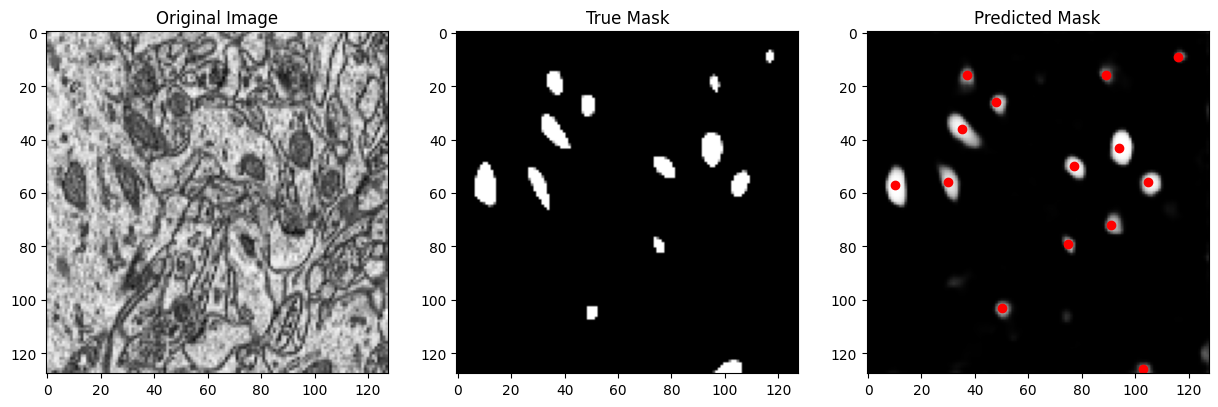

Centroids of predicted mask: [(116, 9), (37, 16), (89, 16), (48, 26), (35, 36), (94, 43), (77, 50), (10, 57), (30, 56), (105, 56), (91, 72), (75, 79), (50, 103), (103, 126)]
Index of the selected image: 1


In [14]:
import random
from scipy import ndimage

# Select a random image
index = random.randint(0, len(X_val) - 1)
# print(len(X_val))

# Predict the mask for the selected image
predicted_mask = model.predict(np.expand_dims(X_val[index], axis=0)).squeeze()

# Find centroids of the predicted mask
centroids = find_centroids(predicted_mask)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(X_val[index].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(y_val[index].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')

# Plot all centroids
for centroid in centroids:
    plt.plot(centroid[0], centroid[1], 'ro')  # Mark centroids with red dots

plt.show()

# Print the coordinates of the centroids
print(f"Centroids of predicted mask: {centroids}")
print(f"Index of the selected image: {index}")
